# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [62]:
import citipy.citipy as citipy, matplotlib.pyplot as plt, numpy as np, pandas as pd, requests, random
from scipy.stats import linregress
from api_keys import weather_api_key
import time

In [63]:
def get_random_floats(low, high, k=1):
    """ Return a unique random floats
        in the range of low <= x <= high
    """
    result = []
    seen = set()
    for i in range(k):
        x=random.uniform(low, high)
        while x in seen:
            x=random.uniform(low, high)
        seen.add(x)
        result.append(x)
    return result

def get_random_lat():
    return random.uniform(-90, 90)

def get_random_lon():
    return random.uniform(-180, 180)

def generate_city_response(city_name):
    url=f"http://api.openweathermap.org/data/2.5/weather?q={city_name}&appid={weather_api_key}&units=imperial"
    return requests.get(url).json()

def print_city(num,city_name):
    print (f"Processing record {(num+1)%50} of set {round((num+1)/50)+1} | {city_name.capitalize()}")

def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.5)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

def scatter_grid(df,x,y,xlabel,ylabel):
    date=time.strftime("%D %H:%M", time.localtime(df.iloc[0,8]))
    date=date[0:8]
    df.plot(kind="scatter",x=x,y=y,title=xlabel+" vs. "+ylabel+" ("+date+")",edgecolors="black",s=35,alpha=0.85)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.grid()
    plt.savefig("output_data/"+xlabel+"-vs-"+ylabel+".png", dpi=100, bbox_inches='tight')
    plt.show()

def scatter_linereg(df,x,y,xlabel,ylabel):
    (slp,inter,rvalue,pvalue,std)=linregress(df[x],df[y])
    print("The r-value is "+str(rvalue))
    df.plot(kind="scatter",x=x,y=y,edgecolors="black",s=35,alpha=0.85,xlabel=xlabel,ylabel=ylabel)
    plt.plot(df[x],inter+slp*df[x],'r-')
    line_eq = "y = " + str(round(slp,2)) + "x + " + str(round(inter,2))
    plt.annotate(line_eq,(df[x].min(),df[y].min()),fontsize=15,color="red")
    plt.savefig('output_data/'+ylabel+'-vs-'+xlabel+'.png')
    plt.show()


## Generate Cities List

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [64]:
latitudes=get_random_floats(-90,90,600)
longitudes=get_random_floats(-180,180,600)
cities_json=[]
for i in range(600):
    city=citipy.nearest_city(latitudes[i],longitudes[i])
    response_json=generate_city_response(city.city_name)
    while response_json in cities_json:
        city=citipy.nearest_city(get_random_lat(),get_random_lon())       
        response_json=generate_city_response(city.city_name)
    try:
        print_city(i,response_json['name'])
    except KeyError:
        print_city(i,city.city_name)
        print("City not found. Skipping...")
        while response_json.get("name")==None:
            city=citipy.nearest_city(get_random_lat(),get_random_lon())       
            response_json=generate_city_response(city.city_name)
            while response_json in cities_json:
                city=citipy.nearest_city(get_random_lat(),get_random_lon())       
                response_json=generate_city_response(city.city_name)
    
    cities_json.append(response_json)
print("-----------------------------\nData Retrieval Complete      \n-----------------------------")

Processing record 1 of set 1 | Sentyabrskiy
City not found. Skipping...
Processing record 2 of set 1 | Taolanaro
City not found. Skipping...
Processing record 3 of set 1 | Yamada
Processing record 4 of set 1 | Coquimbo
Processing record 5 of set 1 | Shingū
Processing record 6 of set 1 | Guerrero negro
Processing record 7 of set 1 | Sabang
Processing record 8 of set 1 | Ushuaia
Processing record 9 of set 1 | Tuatapere
Processing record 10 of set 1 | San patricio
Processing record 11 of set 1 | Northam
Processing record 12 of set 1 | Chokurdakh
Processing record 13 of set 1 | Bambous virieux
Processing record 14 of set 1 | Bluff
Processing record 15 of set 1 | Carnarvon
Processing record 16 of set 1 | Nikolskoye
Processing record 17 of set 1 | Hermanus
Processing record 18 of set 1 | Klaksvík
Processing record 19 of set 1 | Kapaa
Processing record 20 of set 1 | Albany
Processing record 21 of set 1 | Fengzhen
Processing record 22 of set 1 | Praia
Processing record 23 of set 1 | Mahébourg


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [65]:
rows = [[cities_json[i]['name'],cities_json[i]['coord']['lat'],cities_json[i]['coord']['lon'],cities_json[i]['main']['temp_max'],cities_json[i]['main']['humidity'],cities_json[i]['clouds']['all'],cities_json[i]['wind']['speed'],cities_json[i]['sys']['country'],cities_json[i]['dt'] ] for i in range(600)]
df = pd.DataFrame(rows, columns=["City", "Lat","Lon","Max Temp","Humidity","Cloudiness","Wind Speed","Country","Date"])
df=df.drop_duplicates(subset=['City'])
df.to_csv(r'output_data/weather.txt')
len(df['City'])

600

In [66]:
df.head()

,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Mataura,-46.1927,168.8643,41.49,90,100,3.49,NZ,1626810709
1,Brae,60.3964,-1.3530,53.51,81,17,5.44,GB,1626810886
2,Yamada,39.4667,141.9500,73.17,91,42,3.00,JP,1626810886
3,Coquimbo,-29.9533,-71.3436,55.13,76,20,11.50,CL,1626810887
4,Shingū,33.7333,135.9833,73.90,92,38,6.60,JP,1626810887


In [67]:
info=df[["Lat","Lon","Max Temp","Humidity","Cloudiness","Wind Speed","Date"]].agg(['count','mean','std','min',q25,q50,q75,'max'])
info

,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,6.000000e+02
mean,21.769716,15.470761,70.186283,70.381667,52.670000,8.140067,1.626811e+09
std,33.020926,88.192161,14.079626,20.793989,39.428104,5.862755,1.273719e+02
min,-54.800000,-179.166700,33.510000,5.000000,0.000000,0.000000,1.626810e+09
q25,-4.791650,-60.561175,60.645000,59.000000,10.000000,3.740000,1.626811e+09
q50,28.667550,20.825000,72.000000,77.000000,57.000000,6.720000,1.626811e+09
q75,50.261050,82.091800,80.247500,86.000000,95.250000,11.292500,1.626811e+09
max,78.218600,179.316700,111.990000,100.000000,100.000000,37.240000,1.626811e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [68]:
#skipped

In [69]:
#  Get the indices of cities that have humidity over 100%.
#skipped

In [70]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
#skipped

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

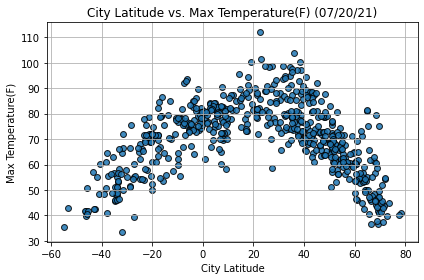

In [71]:
scatter_grid(df,'Lat','Max Temp','City Latitude','Max Temperature(F)')

## Latitude vs. Humidity Plot

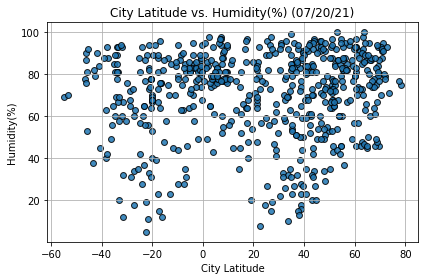

In [72]:
scatter_grid(df,'Lat','Humidity','City Latitude','Humidity(%)')

## Latitude vs. Cloudiness Plot

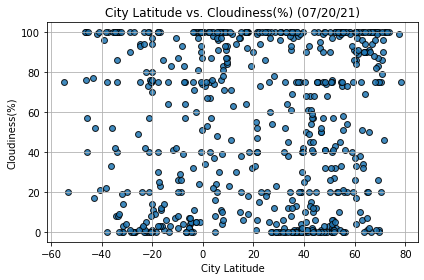

In [73]:
scatter_grid(df,'Lat','Cloudiness','City Latitude','Cloudiness(%)')

## Latitude vs. Wind Speed Plot

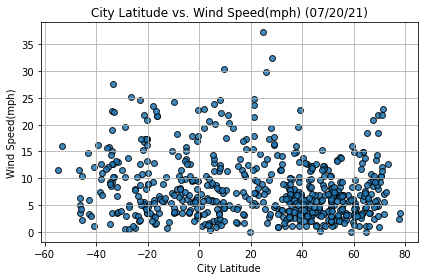

In [74]:
scatter_grid(df,'Lat','Wind Speed','City Latitude','Wind Speed(mph)')

## Linear Regression

In [75]:
north_df=df.loc[df["Lat"]>0]
south_df=df.loc[df["Lat"]<0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is -0.6562221901370141


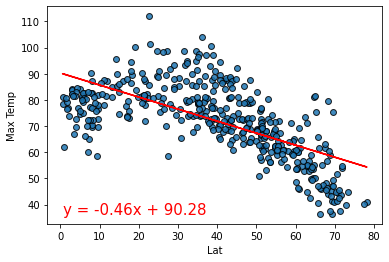

In [76]:
scatter_linereg(north_df,'Lat','Max Temp','City Latitude(North)','Temperature(F)')

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is 0.7968423896764438


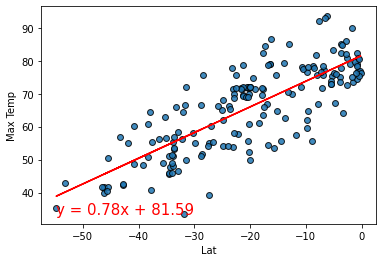

In [77]:
scatter_linereg(south_df,'Lat','Max Temp','City Latitude(South)','Temperature(F)')

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is 0.04200828210738348


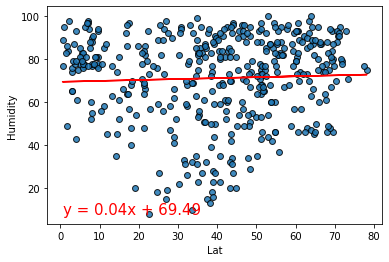

In [78]:
scatter_linereg(north_df,'Lat','Humidity','City Latitude(North)','Humidity(%)')

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is 0.09412412719866926


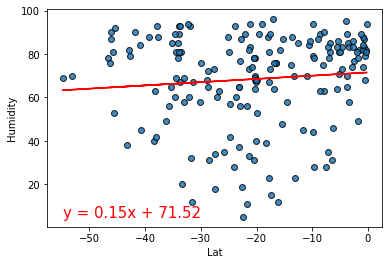

In [79]:
scatter_linereg(south_df,'Lat','Humidity','City Latitude(South)','Humidity(%)')

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is -0.012096535067690328


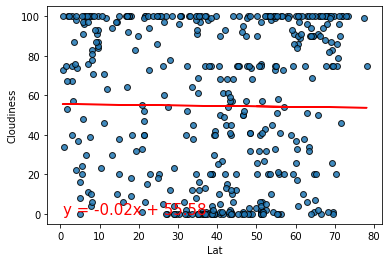

In [80]:
scatter_linereg(north_df,'Lat','Cloudiness','City Latitude(North)','Cloudiness(%)')

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is -0.11983497368628046


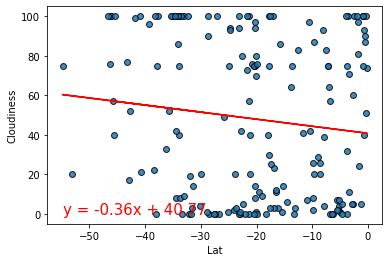

In [81]:
scatter_linereg(south_df,'Lat','Cloudiness','City Latitude(South)','Cloudiness(%)')

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is -0.13951036782398957


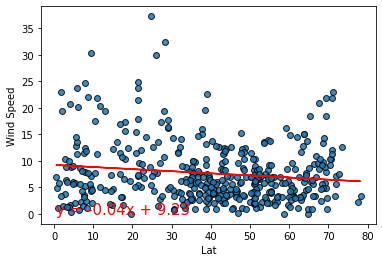

In [82]:
scatter_linereg(north_df,'Lat','Wind Speed','City Latitude(North)','Wind Speed(mph)')

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is -0.07450571662028072


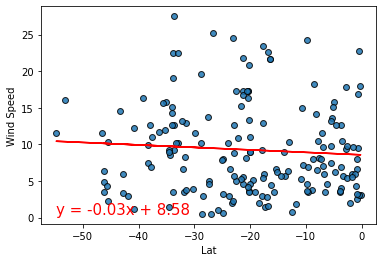

In [83]:
scatter_linereg(south_df,'Lat','Wind Speed','City Latitude(South)','Wind Speed(mph)')